In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression library
from sklearn.linear_model import LogisticRegression

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

### Analysis on K-means Imputed and Outlier Presence dataset

In [2]:
df1 = pd.read_csv("./data_with_outliers_kmeans_imputed.csv")

In [3]:
df1.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.05,10.5,0.05,4.25,11.60,1.99,...,295.0,125.0,526.0,129.0,1077.0,199.0,2737.0,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,69.10,169.0,22.50,132.00,41.80,4.34,...,361.0,147.0,611.0,148.0,1232.0,228.0,3226.0,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.02,25.1,0.30,4.41,13.80,2.30,...,415.0,172.0,701.0,167.0,1358.0,248.0,3675.0,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.28,12.0,0.07,1.88,5.08,1.01,...,194.0,83.0,356.0,89.5,762.0,144.0,1832.0,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.07,16.5,0.15,2.32,8.23,1.52,...,257.0,108.0,456.0,111.0,936.0,171.0,2355.0,12535.0,348.0,155.0


In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,Gd,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
408,132.00,0.0,1.87,0.08,26.10,0.11,2.09,9.77,0.20,74.00,...,449.00,178.00,820.00,170.00,1515.00,266.00,5176.00,14044.00,3911.00,1450.00
2141,35.00,1.0,4.79,0.08,14.00,0.02,0.21,0.40,0.24,3.10,...,14.60,6.00,32.80,8.50,99.00,24.30,216.00,11411.00,202.00,84.00
809,1635.92,0.0,11.43,1.27,12.69,0.49,6.17,10.41,0.54,49.51,...,173.57,60.56,266.24,51.79,442.68,77.43,365.04,10823.69,593.44,353.33
1439,906.00,0.0,3.86,0.01,20.40,0.09,2.13,6.03,0.12,42.90,...,189.00,71.90,306.00,59.30,485.00,90.20,1972.00,10943.00,397.00,258.00
2588,370.00,1.0,5.09,0.05,15.84,0.02,0.39,1.26,0.33,8.12,...,44.74,20.14,111.75,29.79,364.43,64.84,639.05,11528.52,191.88,71.82


In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### PCA

In [10]:
pca = PCA(n_components=15)

X_train_transform = pca.fit_transform(X_train_scaled)
X_test_transform = pca.transform(X_test_scaled)

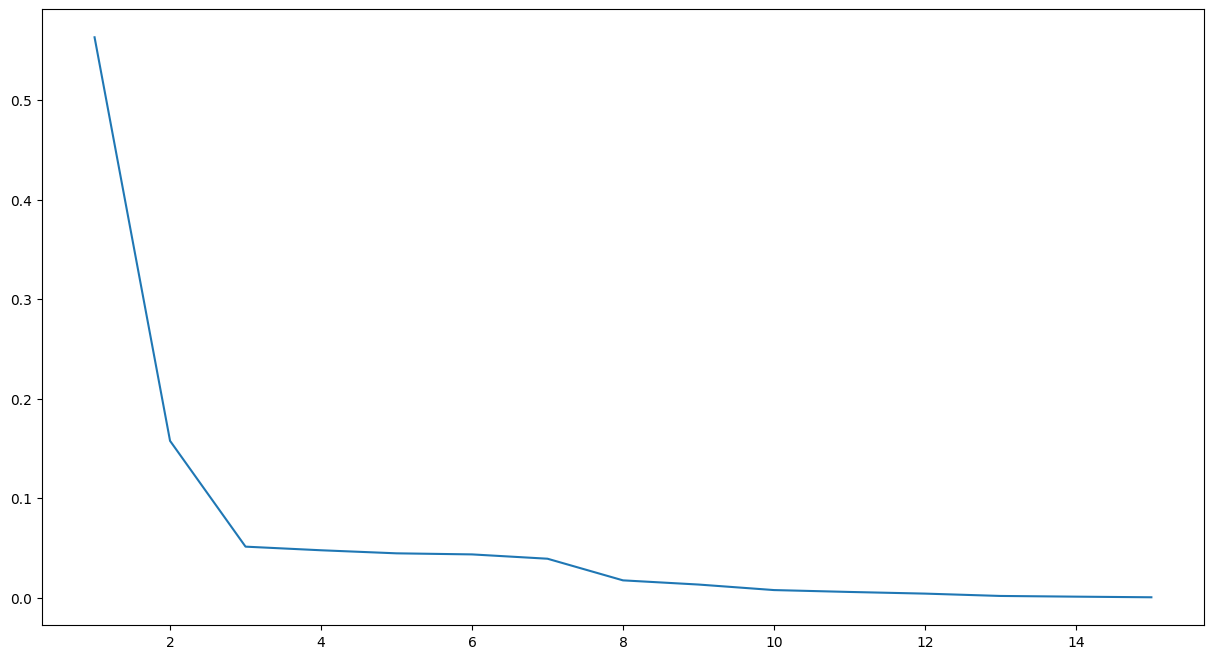

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_)

### Fitting the base model

In [14]:
rf_base = ensemble.RandomForestClassifier()

rf_base.fit(X_train_transform, y_train)

RandomForestClassifier()

In [15]:
y_pred = rf_base.predict(X_test_transform)

In [17]:
print("Accuracy of test set on base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of test set on base model:  0.94


In [18]:
print("Classification report of test set: \n\n", classification_report(y_test, y_pred))

Classification report of test set: 

               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       330
         1.0       0.97      0.89      0.93       268

    accuracy                           0.94       598
   macro avg       0.94      0.93      0.94       598
weighted avg       0.94      0.94      0.94       598



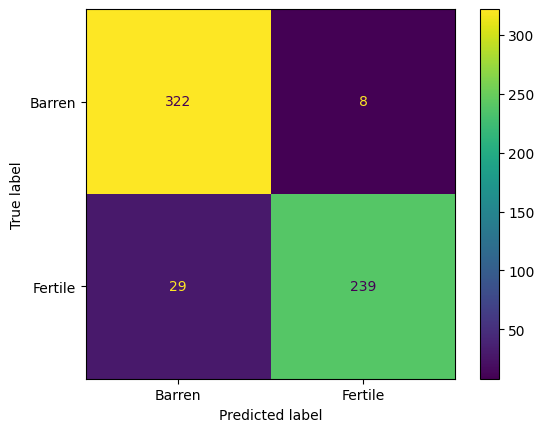

In [19]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper-Parameter Tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [20]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [24]:
param_grid = {
    
    'max_depth': np.arange(3, 15, 2),
    'n_estimators': np.arange(100, 500, 100),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
    
}

In [25]:
clf = GridSearchCV(estimator = ensemble.RandomForestClassifier(), param_grid=param_grid, scoring='accuracy',
                   cv = Stratified_kf, n_jobs=-1, verbose=10, return_train_score=True)

In [26]:
clf.fit(X_train_transform, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([100, 200, 300, 400])},
             return_train_score=True, scoring='accuracy', verbose=10)

In [27]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=13)

In [44]:
clf.best_score_

0.9410041841004185

In [28]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [29]:
print("Best accuracy obtained: ", round(clf.best_score_, 2))

Best accuracy obtained:  0.94


### Hyper-Parameter Tuning using Bayesian Optimization

In [30]:
def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(**params)
    kfold = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    
    for idx in kfold.split(X=x, y=y):
        train_idx, valid_idx = idx[0], idx[1]        
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xvalid = x[valid_idx]
        yvalid = y[valid_idx]
        
        model.fit(xtrain, ytrain)        
        preds = model.predict(xvalid)        
        fold_accuracy = accuracy_score(yvalid, preds)
        
        accuracies.append(fold_accuracy)
        
    return -1.0 * np.mean(accuracies)

In [33]:
param_space = [
    space.Integer(3, 13, name='max_depth'),
    space.Integer(100, 500, name='n_estimators'),
    space.Categorical(categories=['gini', 'entropy'], name='criterion'),
    space.Categorical(['sqrt', 'log2'], name='max_features')
]

In [34]:
param_names = ['max_depth', 'n_estimators', 'criterion',  'max_features']

In [36]:
optimization_function = partial(optimize, param_names = param_names, x = X_train_transform, y = y_train)

In [37]:
result = gp_minimize(func=optimization_function,
                     dimensions = param_space,
                     n_calls=5,
                     n_random_starts=5,
                     verbose=10,
                     n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.5167
Function value obtained: -0.9305
Current minimum: -0.9305
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3989
Function value obtained: -0.9100
Current minimum: -0.9305
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.8255
Function value obtained: -0.8958
Current minimum: -0.9305
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.2440
Function value obtained: -0.9343
Current minimum: -0.9343
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.4996
Function value obtained: -0.8778
Current minimum: -0.9343


In [38]:
best_params = dict(zip(param_names, result.x))
print(best_params)

{'max_depth': 12, 'n_estimators': 297, 'criterion': 'entropy', 'max_features': 'log2'}
[CV 3/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 3/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.827, test=0.816) total time=   0.5s
[CV 10/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 10/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.829, test=0.833) total time=   0.4s
[CV 8/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 8/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.826, test=0.828) total time=   0.9s
[CV 6/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 6/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.831, test=0.820) total time=   1.3s
[CV 4/10; 4

[CV 7/10; 1/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100
[CV 7/10; 1/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100;, score=(train=0.830, test=0.791) total time=   0.4s
[CV 4/10; 2/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200
[CV 4/10; 2/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200;, score=(train=0.828, test=0.845) total time=   0.9s
[CV 2/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 2/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.835, test=0.816) total time=   1.3s
[CV 10/10; 3/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300
[CV 10/10; 3/96] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300;, score=(train=0.828, test=0.841) total time=   1.2s
[CV 8/10; 4/96] START criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400
[CV 8/10; 4

In [39]:
best_model_rf = ensemble.RandomForestClassifier(**best_params)

In [40]:
best_model_rf.fit(X_train_transform, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, max_features='log2',
                       n_estimators=297)

In [41]:
preds_best_rf = best_model_rf.predict(X_test_transform)

In [43]:
print("Accuracy using Bayesian Optimization: ", round(accuracy_score(y_test, preds_best_rf), 2))

Accuracy using Bayesian Optimization:  0.94
